# Responsible Data Science Spring 2021: Homework 2

This notebook contains sample code; other methods at arriving at the correct answer were also accepted.

Install the Data Synthesizer library.

In [2]:
!pip install DataSynthesizer

     |████████████████████████████████| 22.3MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import normalize_given_distribution, read_json_file, pairwise_attributes_mutual_information, mutual_information, set_random_seed, display_bayesian_network

from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

Start with a real dataset __hw_compas__ and a fake dataset __hw_xyz__. Generate synthetic datasets of size __N=10000__, in the following four categories:
- A:  random mode
- B: independent attribute mode with __epsilon = 0.1__
- C:  correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=1
- D: correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=2

In [4]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. 
# Please follow the steps as instructed when you run the following commands. 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
fileid_compas = '12nKVg66nQkHX9gLFL-wXpgppCNSoasFJ'    
real_data_file = 'hw_compas.csv'

fileid_fake = '125JShDZAur7zQSugMoLi-JiIohtcvGY1'    
fake_data_file = 'hw_fake.csv'

downloaded = drive.CreateFile({'id':fileid_compas}) 
downloaded.GetContentFile(real_data_file)  
df_real = pd.read_csv(real_data_file)

downloaded = drive.CreateFile({'id':fileid_fake}) 
downloaded.GetContentFile(fake_data_file)  
df_fake = pd.read_csv(fake_data_file)

In [6]:
# Write code here to generate the datasets
#initialize describer and generator 
describer = DataDescriber()
generator = DataGenerator()

#set up some paths
description_files_compas = {'random mode':                   'description(random).json', 
                     'independent attribute mode':    'description(independent).json', 
                     'correlated attribute mode 1':     'description(correlated 1).json',
                     'correlated attribute mode 2':     'description(correlated 2).json'}

synthetic_data_files_compas = {'random mode':                'synthetic data(random).csv', 
                        'independent attribute mode': 'synthetic data(independent).csv', 
                        'correlated attribute mode 1':  'synthetic data(correlated 1).csv',
                        'correlated attribute mode 2':  'synthetic data(correlated 2).csv'}

description_files_fake = {'random mode':                   'description(random).json', 
                     'independent attribute mode':    'description(independent).json', 
                     'correlated attribute mode 1':     'description(correlated 1).json',
                     'correlated attribute mode 2':     'description(correlated 2).json'}

synthetic_data_files_fake = {'random mode':                'synthetic data(random).csv', 
                        'independent attribute mode': 'synthetic data(independent).csv',
                        'correlated attribute mode 1':  'synthetic data(correlated 1).csv', 
                        'correlated attribute mode 2':  'synthetic data(correlated 2).csv'}


output_data_size = 10000

In [7]:
df_real.head()

,sex,age,race,score
0,Male,69,Other,1
1,Male,31,Caucasian,5
2,Male,34,African-American,3
3,Male,24,African-American,4
4,Male,23,African-American,8


# Generate Data Set for the Real Data File

In [9]:
#generate data set for hw_compas random mode.
describer.describe_dataset_in_random_mode(real_data_file) 
describer.save_dataset_description_to_file(description_files_compas['random mode'])

generator.generate_dataset_in_random_mode(n=output_data_size, 
                                          description_file=description_files_compas['random mode'], 
                                          seed=0, 
                                          minimum=0, 
                                          maximum=100)

#save the synethetic data 
generator.save_synthetic_data(synthetic_data_files_compas['random mode'])

#convert to dataframe
synthetic_random_compas = pd.read_csv(synthetic_data_files_compas['random mode'])
synthetic_random_compas.head()

,sex,age,race,score
0,Male,9,Native American,10
1,Female,35,Hispanic,1
2,Female,78,Other,6
3,Male,32,African-American,6
4,Female,58,Hispanic,9


In [10]:
#generate data set for hw_compas independent attribute mode with epsilon = 0.1.
describer.describe_dataset_in_independent_attribute_mode(real_data_file, epsilon=0.1)
describer.save_dataset_description_to_file(description_files_compas['independent attribute mode'])
generator.generate_dataset_in_independent_mode(n=output_data_size,description_file=description_files_compas['independent attribute mode'],seed=0,)


#save the synethetic data 
generator.save_synthetic_data(synthetic_data_files_compas['independent attribute mode'])

#convert to dataframe
synthetic_independent_compas = pd.read_csv(synthetic_data_files_compas['independent attribute mode'])
synthetic_independent_compas.head()

,sex,age,race,score
0,Male,45.0,African-American,7
1,Male,25.0,African-American,4
2,Male,27.0,Native American,1
3,Male,19.0,African-American,8
4,Male,20.0,Other,4


In [11]:
#generate data set for hw_compas C: correlated attribute mode with epsilon = 0.1, with Bayesian network degree k=1
describer.describe_dataset_in_correlated_attribute_mode(real_data_file, 
                                                        epsilon=0.1, 
                                                        k=1)
describer.save_dataset_description_to_file(description_files_compas['correlated attribute mode 1'])
generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size,description_file=description_files_compas['correlated attribute mode 1'],seed=0,)

#save the synethetic data 
generator.save_synthetic_data(synthetic_data_files_compas['correlated attribute mode 1'])

#convert to dataframe
synthetic_correlated_1_compas = pd.read_csv(synthetic_data_files_compas['correlated attribute mode 1'])

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


In [12]:
#generate data set for hw_compas C: correlated attribute mode with epsilon = 0.1, with Bayesian network degree k=2
describer.describe_dataset_in_correlated_attribute_mode(real_data_file, 
                                                        epsilon=0.1, 
                                                        k=2)
describer.save_dataset_description_to_file(description_files_compas['correlated attribute mode 2'])
generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size,description_file=description_files_compas['correlated attribute mode 2'],seed=0,)

#save the synethetic data 
generator.save_synthetic_data(synthetic_data_files_compas['correlated attribute mode 2'])

#convert to dataframe
synthetic_correlated_2_compas = pd.read_csv(synthetic_data_files_compas['correlated attribute mode 2'])

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


#Generate data set for the fake data file 


In [13]:
#generate data set for fake_data_file random mode.
describer.describe_dataset_in_random_mode(fake_data_file) 
describer.save_dataset_description_to_file(description_files_fake['random mode'])

generator.generate_dataset_in_random_mode(n=output_data_size, 
                                          description_file=description_files_fake['random mode'], 
                                          seed=0, 
                                          minimum=0, 
                                          maximum=100)

#save the synethetic data 
generator.save_synthetic_data(synthetic_data_files_fake['random mode'])

#convert to dataframe
synthetic_random_fake = pd.read_csv(synthetic_data_files_fake['random mode'])
synthetic_random_fake.head()

,parent_1,parent_2,child_1,child_2
0,0,1,1,1
1,2,2,0,0
2,0,1,0,1
3,2,1,0,2
4,2,0,2,2


In [14]:
#generate data set for fake_data_file independent attribute mode with epsilon = 0.1.
describer.describe_dataset_in_independent_attribute_mode(fake_data_file, epsilon=0.1)
describer.save_dataset_description_to_file(description_files_fake['independent attribute mode'])
generator.generate_dataset_in_independent_mode(n=output_data_size,description_file=description_files_fake['independent attribute mode'],seed=0,)


#save the synethetic data 
generator.save_synthetic_data(synthetic_data_files_fake['independent attribute mode'])

#convert to dataframe
synthetic_independent_fake = pd.read_csv(synthetic_data_files_fake['independent attribute mode'])

In [15]:
#generate data set for fake_data_file correlated attribute mode with epsilon = 0.1, with Bayesian network degree k=1
describer.describe_dataset_in_correlated_attribute_mode(fake_data_file, 
                                                        epsilon=0.1, 
                                                        k=1)
describer.save_dataset_description_to_file(description_files_fake['correlated attribute mode 1'])
generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size,description_file=description_files_fake['correlated attribute mode 1'],seed=0,)

#save the synethetic data 
generator.save_synthetic_data(synthetic_data_files_fake['correlated attribute mode 1'])


#convert to dataframe
synthetic_correlated_1_fake = pd.read_csv(synthetic_data_files_fake['correlated attribute mode 1'])

================ Constructing Bayesian Network (BN) ================
Adding ROOT child_2
Adding attribute parent_2
Adding attribute child_1
Adding attribute parent_1
========================== BN constructed ==========================


In [16]:
#generate data set for hw_compas C: correlated attribute mode with epsilon = 0.1, with Bayesian network degree k=2
describer.describe_dataset_in_correlated_attribute_mode(fake_data_file, 
                                                        epsilon=0.1, 
                                                        k=2)
describer.save_dataset_description_to_file(description_files_fake['correlated attribute mode 2'])
generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size,description_file=description_files_fake['correlated attribute mode 2'],seed=0,)

#save the synethetic data 
generator.save_synthetic_data(synthetic_data_files_fake['correlated attribute mode 2'])

#convert to dataframe
synthetic_correlated_2_fake = pd.read_csv(synthetic_data_files_fake['correlated attribute mode 2'])

================ Constructing Bayesian Network (BN) ================
Adding ROOT child_2
Adding attribute parent_2
Adding attribute child_1
Adding attribute parent_1
========================== BN constructed ==========================


## Part (a)

### Q1

Median, Mean, Min, Max of __age__ for each setting A, B, C and D, compare to the ground truth value in __hw_compas__, present results in a table

In [17]:
def stats(df, column):
  median = df[column].median()
  mean = df[column].mean()
  min = df[column].min()
  max = df[column].max()
  stats = np.array([median,mean,min,max])
  return stats




In [18]:
A_compas = stats(synthetic_random_compas,"age")
B_compas = stats(synthetic_independent_compas,"age")
C_compas = stats(synthetic_correlated_1_compas,"age")
D_compas = stats(synthetic_correlated_2_compas,"age")
real_compas = stats(df_real, "age")



In [19]:
df_stats = pd.DataFrame({"A": A_compas, 
                         "B": B_compas,
                         "C": C_compas,
                         "D": D_compas,
                         "real": real_compas},
                        index = ['median','mean','min','max'])
df_stats

,A,B,C,D,real
median,50.0000,32.0000,38.0000,40.0000,32.000000
mean,50.3008,36.8834,45.2641,45.5815,35.143319
min,0.0000,18.0000,18.0000,18.0000,18.000000
max,100.0000,96.0000,96.0000,96.0000,96.000000


In the random mode, we replace the feature(s) that we want to protect with random values drawn from a uniform distribution. So we can see that the median, mean, min, and max of the random mode are considered to be the furtherest from the real data file. 


In the indpendent attribute mode, we replace the feature we want to protect with values that follow the same distribution as the original data. However, we do not consider any other features when determining the new value for the sensitive feature. we can see that median, mean, min, max of the age feature are considered to be the closet to the actual compas dataset. 


In the correlated attribute mode with Bayesian network degree k=1 and k=2, we replace the feature we want to protect with values based on the conditional distribution of all the features in the database. This is calculated using a Bayesian network. We can see that the min, max of the correlated attribute mode conincide with the actual compas dataset. However, the median and mean are bit far off with the actual compas dataset.

### Q2

Plot the distributions of values of age and sex attributes in hw_compas and in synthetic datasets generated under settings A and B. 
Some more sophisticated statistical measure that’s good for independent attribute mode - __Two-sample Kolmogorov–Smirnov test__ and __KL-divergence__. Also show the difference visually, comparing real vs. synthetic

#### Two-sample Kolmogorov–Smirnov test for continous attributes

In [20]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

#### KL-divergence for categorical attributes

In [21]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

# Plot the distributions of values of age and sex attributes in hw_compas and in synthetic datasets generated under settings A and B

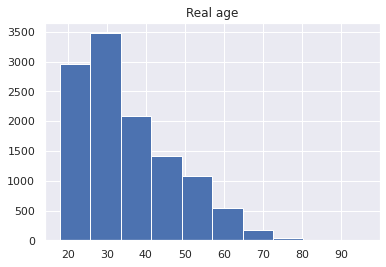

In [22]:
plt.hist(df_real.age)
plt.title('Real age')
plt.show()


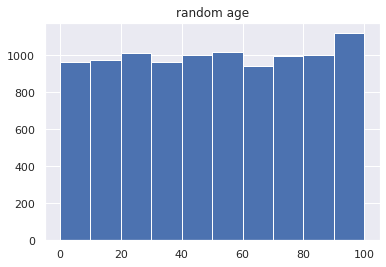

In [23]:
plt.hist(synthetic_random_compas.age)
plt.title('random age')
plt.show()

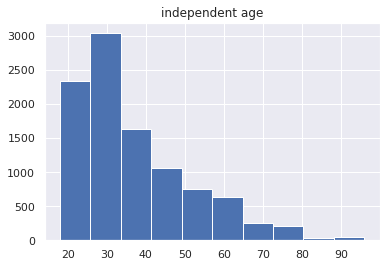

In [24]:
plt.hist(synthetic_independent_compas.age)
plt.title('independent age')
plt.show()

Distributions of values of age in hw_compas and in synthetic datasets generated under random mode appears to be uniform. Since I know in advance that we replace the feature(s) that we want to protect with random values drawn from a uniform distribution. It is reasonable that the age distribution is uniform. 

Distributions of values of age in hw_compas and in synthetic datasets generated under independent mode appears to be very close to the compas's actual age distribution. Since we know in advance that in independent attribute mode, we replace the feature we want to protect with values that follow the same distribution as the original data. So it is reasonable that the age distribution of the synthetic data is close to the actual distribution. 




# Plot the distributions of values of sex attributes in hw_compas and in synthetic datasets generated under settings A and B

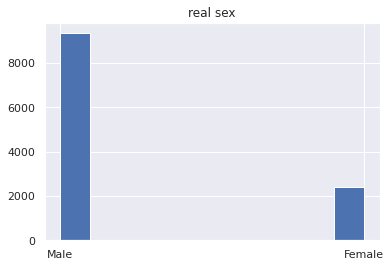

In [25]:
plt.hist(df_real.sex)
plt.title('real sex')
plt.show()

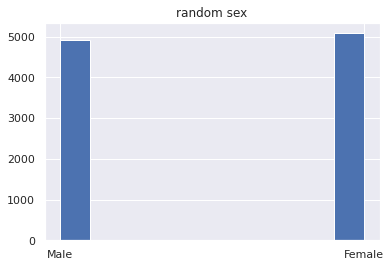

In [26]:
plt.hist(synthetic_random_compas.sex)
plt.title('random sex')
plt.show()

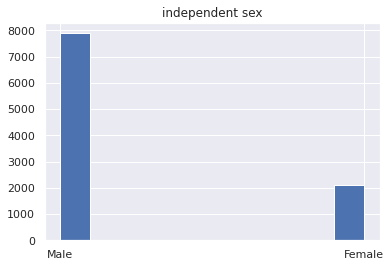

In [27]:
plt.hist(synthetic_independent_compas.sex)
plt.title('independent sex')
plt.show()

Distributions of values of sex in hw_compas and in synthetic datasets generated under random mode appears to be pretty balanced. Since I know in advance that we replace the feature(s) that we want to protect with random values drawn from a uniform distribution. It is reasonable that the sex distribution is pretty balanced between male and female.

Distributions of values of sex in hw_compas and in synthetic datasets generated under independent mode appears to be very close to the compas's actual sex distribution. Since we know in advance that in independent attribute mode, we replace the feature we want to protect with values that follow the same distribution as the original data. So it is reasonable that the sex distribution of the synthetic data is close to the actual distribution.

Two-sample Kolmogorov-Smirnov test (KS test) for the numerical
attribute age

In [28]:
#under condition A 
ks_test(df_real, synthetic_random_compas, 'age')

0.373353049247257

In [29]:
#under condition B
ks_test(df_real, synthetic_independent_compas, 'age')

0.053053049247256956

The Kolmogorov-Smirnov test quantifies the similarity between the empirical distribution functions two sets of data. We can use it to measure how well the distribution of our synthetic data mimics the distribution of the original dataset. The Kolmogorov–Smirnov test statistic is the maxium distance between the two CDFs. 

we could see that under the condition A, the ks test score is pretty large which make sense since the synthetic age distribution is uniformly distributed and different from the actual age distribution. Therefore, the maximum distance between the two CDFs is relatively large, and ks score is quite large. 

On the other hand, under the condition B, the ks test score is relatively small, which also make sense since the synthetic age distribution ought be similar to the actual distribution. Therefore, the maximum distance between the two CDFs is relatively small, and in turn the ks score is small. 

Kullback-Leibler divergence (KL-divergence) for the categorical attribute sex 

In [30]:
#under condition A 
kl_test(df_real, synthetic_random_compas, 'sex')

0.22388927416119944

In [31]:
#under condition B 
kl_test(df_real, synthetic_independent_compas, 'sex')

7.844002303542246e-05

The KL-divergence is an alternative way to measure the difference between two distributions. This metric works on discrete/categorical variables.

we could see that under the condition A, the kl test score is pretty large which make sense since the synthetic sex should be uniformly distributed between female and male which is different from the actual sex distribution. Therefore, the ks score is quite large.

On the other hand, under the condition B, the kl test score is relatively small, which also make sense since the synthetic sex distribution ought be similar to the actual distribution. Therefore, the kl score is small.


### Q3

Compare the accuracy of correlated attribute mode with k=1 (C) and with k=2 (D). Display the __pairwise mutual information matrix by heatmaps__, showing mutual information between all pairs of attributes, in hw_fake and in two synthetic datasets (generated under C and D).

In [32]:
# Use pairwise_attributes_mutual_information function. 
# For function parameters, refer to https://github.com/DataResponsibly/DataSynthesizer/blob/master/DataSynthesizer/lib/utils.py#L31


In [33]:
pairwise_attributes_mutual_information(synthetic_correlated_1_fake)

,child_1,child_2,parent_1,parent_2
child_1,1.000000,0.007344,0.000981,0.289825
child_2,0.007344,1.000000,0.194178,0.130105
parent_1,0.000981,0.194178,1.000000,0.027984
parent_2,0.289825,0.130105,0.027984,1.000000


In [35]:
pairwise_attributes_mutual_information(df_fake)

,child_1,child_2,parent_1,parent_2
child_1,1.000000,0.211242,0.214345,0.195899
child_2,0.211242,1.000000,0.208301,0.200690
parent_1,0.214345,0.208301,1.000000,0.002421
parent_2,0.195899,0.200690,0.002421,1.000000


We know that mutual information is defined as follows for two discrete variables X and Y, 
$$I(X; Y) = \sum_{y \in Y} \sum_{x \in X} p(x,y) \log(\frac{p(x,y)}{p(x)p(y)})$$

Higher values indicate greater levels of mutual information. We could use the calculated mutual information scores to see how well the relationships between features are preserved in the synthetic data. 

From the Correlated attribute mode with k=1 (C) pairwise mutual information comparison plot, 

we could see that the mutual information score of child 1 and parent 2 in the synthetic data(0.289825) is similar to the score of the fake data set(0.195899). So the relationship between child 1 and parent 2 is preserved. 

However, the mutual information score of child 1 and parent 1 in the synthetic data is far off from the fake data set. In the synthetic dataset, the score is 0.000981, but in the fake data file, the score is 0.214345. The relationship is not preserved. 

we could see that the mutual information score of child 2 and parent 1 in the synthetic data(0.194178) is similar to the score of the fake data set(0.208301). So the relationship between child 2 and parent 1 is preserved. 

we could also see that the mutual information score of child 2 and parent 2 in the synthetic data(0.130105) is kind of close to the score of the fake data set(0.200690). So the relationship between child 2 and parent 2 is kind of preserved. 

Since the parent 1 and parent 2 take on the value independently, these two variables ought to have a close to 0 mutual information score. This is shown in the fake data file.In the synthetic data file, this characteristic is shown because the synthetic score (0.027984) is close to 0. The relationship of parent 1 and parent 2 is kind of preserved. 

Since the child 1 and child 2 take on the value of parent 1 or parent 2 with equal chances with equal chances, there should exist some level of mutual information. This is shown in the fake data file, the score between child 1 and child 2 is 0.211242, however, in the synthetic data, the score is way lower(0.007344). The relationship of child 1 and child 2 is not preserved. 



In [41]:
pairwise_attributes_mutual_information(df_fake)

,child_1,child_2,parent_1,parent_2
child_1,1.000000,0.211242,0.214345,0.195899
child_2,0.211242,1.000000,0.208301,0.200690
parent_1,0.214345,0.208301,1.000000,0.002421
parent_2,0.195899,0.200690,0.002421,1.000000


In [37]:
pairwise_attributes_mutual_information(synthetic_correlated_2_fake)

,child_1,child_2,parent_1,parent_2
child_1,1.000000,0.155061,0.043875,0.042497
child_2,0.155061,1.000000,0.183781,0.059603
parent_1,0.043875,0.183781,1.000000,0.072291
parent_2,0.042497,0.059603,0.072291,1.000000


From the Correlated attribute mode with k=2 (D) pairwise mutual information comparison plot, 

we could see that the mutual information score of child 1 and parent 2 in the synthetic data(0.042497) is far from the score of the fake data set(0.195899). So the relationship between child 1 and parent 2 is not preserved. 

The mutual information score of child 1 and parent 1 in the synthetic data is far off from the fake data set. In the synthetic dataset, the score is 0.214345, but in the fake data file, the score is 0.043875. The relationship is not preserved. 

we could see that the mutual information score of child 2 and parent 1 in the synthetic data(0.183781) is similar to the score of the fake data set(0.208301). So the relationship between child 2 and parent 1 is preserved. 

we could also see that the mutual information score of child 2 and parent 2 in the synthetic data(0.059603) is far from the score of the fake data set(0.200690). So the relationship between child 2 and parent 2 is not preserved. 

Since the parent 1 and parent 2 take on the value independently, these two variables ought to have a close to 0 mutual information score. This is shown in the fake data file.In the synthetic data file, this characteristic is shown because the synthetic score (0.072291) is close to 0. The relationship of parent 1 and parent 2 is kind of preserved. 

Since the child 1 and child 2 take on the value of parent 1 or parent 2 with equal chances with equal chances, there should exist some level of mutual information. This is shown in the fake data file, the score between child 1 and child 2 is 0.211242. In the synthetic data, the score is 0.155061. The relationship of child 1 and child 2 is kind of preserved. 



All in all, I would say that the correlated attribute with k = 1 preserve the relationships between attributes better than the correlated attribute with k = 2. I think this is because the original fake data file there is only 1 parent for each children. So the k = 1 correlated attribute mode (each children would have 1 parent) would be able to preserve the correlation between the variable. However, the k = 2 correlated attribute mode(each children have maximum 2 parents), it is unable to preserve the correlations between the variables as well because there are too much information provided to the network, making the synthetic data carry unnecessary “correlation”. 

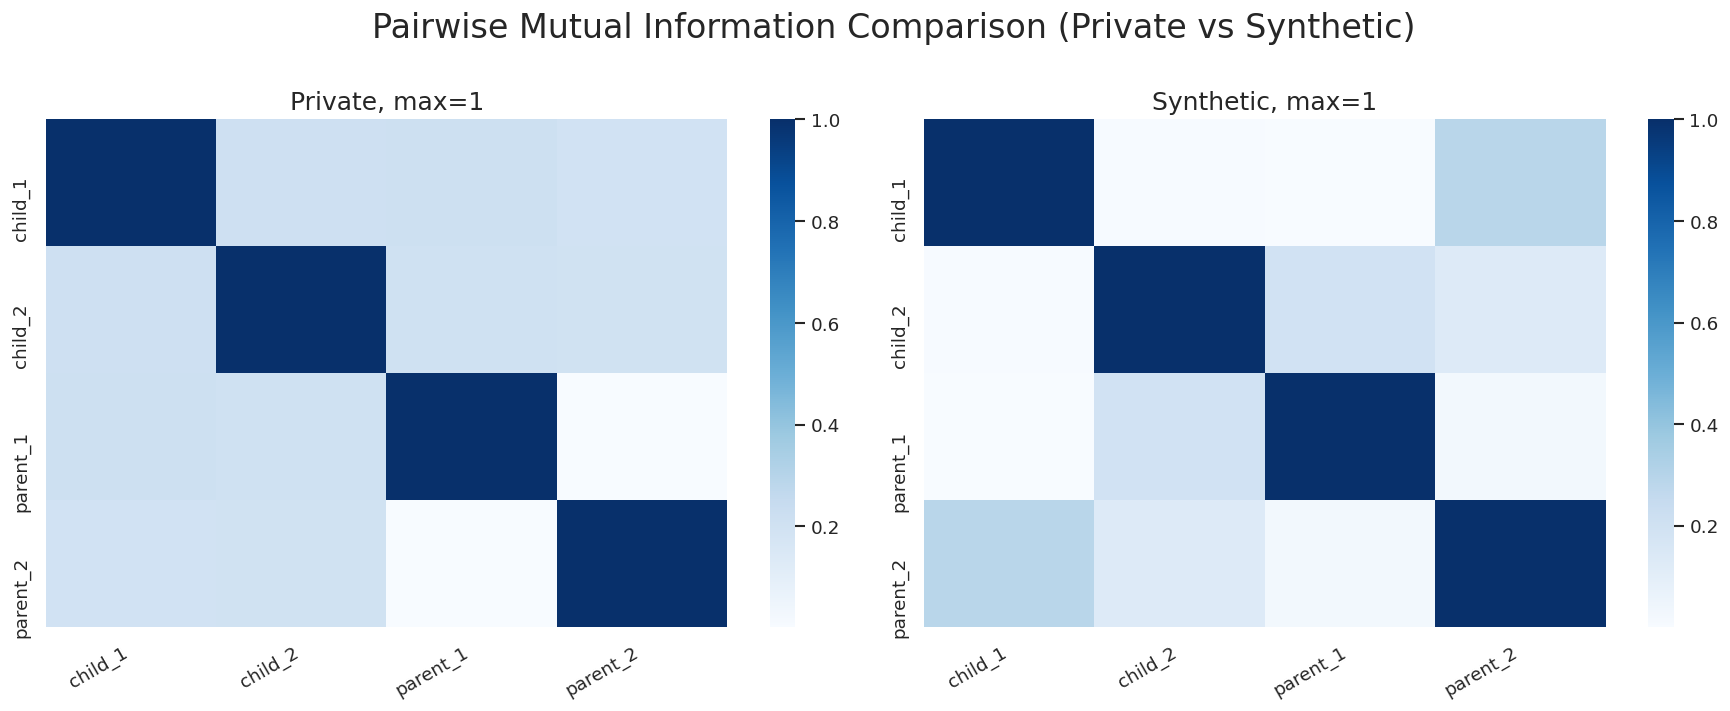

In [36]:
# Use can sns.heatmap for pairwise mutual information
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.heatmap.html
attribute_description_1 = read_json_file(description_files_fake['correlated attribute mode 1'])['attribute_description']
ModelInspector(df_fake,synthetic_correlated_1_fake, attribute_description_1).mutual_information_heatmap()

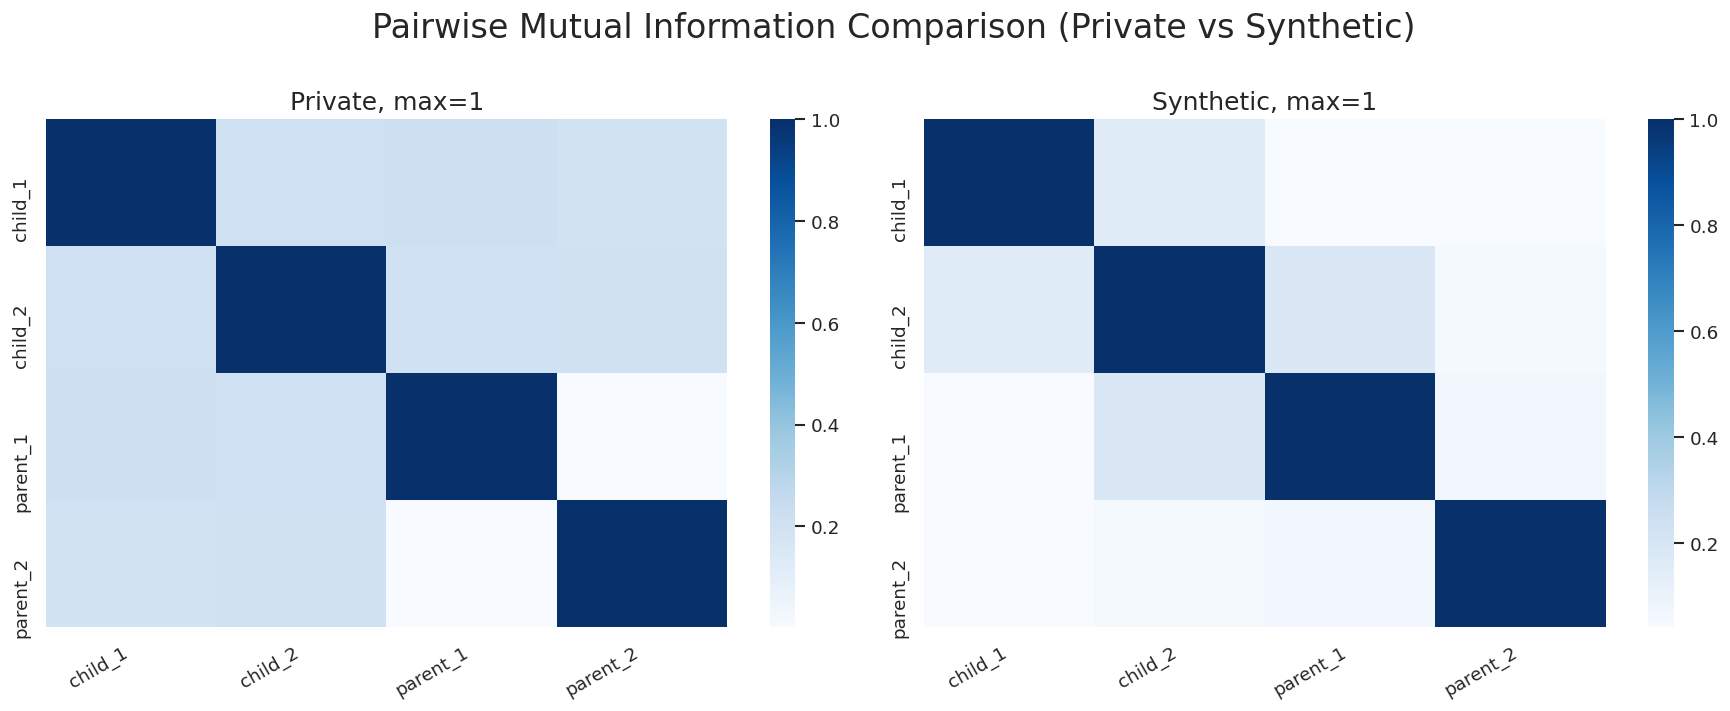

In [39]:
attribute_description_2 = read_json_file(description_files_fake['correlated attribute mode 2'])['attribute_description']
ModelInspector(df_fake,synthetic_correlated_2_fake, attribute_description_2).mutual_information_heatmap()

## Part (b)

Study the variability in accuracy of answers to Q1 and Q2 for data generation mode A, B and C: fix epsilon = 0.1, generate __10__ synthetic databases (by specifying different seeds).  Plot accuracy as a box-and-whiskers plot.  

In [ ]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html

In [44]:
#created path for the part B
description_files_compasB = {'random mode':                   'description(random).json', 
                     'independent attribute mode':    'description(independent).json', 
                     'correlated attribute mode 1':     'description(correlated 1).json',
                     }
synthetic_data_files_compasB = {'random mode':                'synthetic data(random).csv', 
                        'independent attribute mode': 'synthetic data(independent).csv', 
                        'correlated attribute mode 1':  'synthetic data(correlated 1).csv'}
   

# Random Mode 

In [45]:

random_medians = []
random_means = []
random_mins = []
random_maxs = []
seeds = [99,5,45,30,88,36,21,12,68,1]

for seed in seeds:
  current_seed = seed

  describer.describe_dataset_in_random_mode(real_data_file) 
  describer.save_dataset_description_to_file(description_files_compasB['random mode'])
  # generate in random mode
  generator.generate_dataset_in_random_mode(n=output_data_size,description_file=description_files_compasB['random mode'],seed=current_seed,minimum=0, 
                                          maximum=100)
  
  #save the synethetic data 
  generator.save_synthetic_data(synthetic_data_files_compasB['random mode'])

  #convert to dataframe
  synthetic_random_compasB = pd.read_csv(synthetic_data_files_compasB['random mode'])
  #calculate median
  median = synthetic_random_compasB['age'].median()
  random_medians.append(median)

  #calculate mean
  mean = synthetic_random_compasB['age'].mean()
  random_means.append(mean)

  #calculate min
  min = synthetic_random_compasB['age'].min()
  random_mins.append(min)

  #calculate max
  max = synthetic_random_compasB['age'].max()
  random_maxs.append(max)






[50.0, 50.0, 50.0, 50.0, 49.0, 50.0, 49.0, 50.0, 50.0, 50.0] [49.9342, 50.0036, 50.1339, 50.2038, 49.7899, 49.8091, 49.7355, 49.9518, 49.9401, 49.6333] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [46]:
independet_medians = []
independet_means = []
independet_mins = []
independet_maxs = []
seeds = [99,5,45,30,88,36,21,12,68,1]
for seed in seeds:
  current_seed = seed

  describer.describe_dataset_in_independent_attribute_mode(real_data_file, epsilon=0.1)
  describer.save_dataset_description_to_file(description_files_compasB['independent attribute mode'])
  # generate in independent attribute mode
  generator.generate_dataset_in_independent_mode(n=output_data_size,description_file=description_files_compasB['independent attribute mode'],seed=current_seed, 
                                          )
  
  #save the synethetic data 
  generator.save_synthetic_data(synthetic_data_files_compasB['independent attribute mode'])

  #convert to dataframe
  synthetic_independent_compasB = pd.read_csv(synthetic_data_files_compasB['independent attribute mode'])
  #calculate median
  median = synthetic_independent_compasB['age'].median()
  independet_medians.append(median)

  #calculate mean
  mean = synthetic_independent_compasB['age'].mean()
  independet_means.append(mean)

  #calculate min
  min = synthetic_independent_compasB['age'].min()
  independet_mins.append(min)

  #calculate max
  max = synthetic_independent_compasB['age'].max()
  independet_maxs.append(max)




In [47]:
correlated_medians = []
correlated_means = []
correlated_mins = []
correlated_maxs = []
seeds = [99,5,45,30,88,36,21,12,68,1]

for seed in seeds:
  current_seed = seed

  describer.describe_dataset_in_correlated_attribute_mode(real_data_file, epsilon=0.1, k=1)
  describer.save_dataset_description_to_file(description_files_compasB['correlated attribute mode 1'])
  # generate in correlated attribute mode
  generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size,description_file=description_files_compasB['correlated attribute mode 1'],seed=current_seed, )
  
  #save the synethetic data 
  generator.save_synthetic_data(synthetic_data_files_compasB['correlated attribute mode 1'])

  #convert to dataframe
  synthetic_correlated_1_compasB = pd.read_csv(synthetic_data_files_compasB['correlated attribute mode 1'])
  #calculate median
  median =  synthetic_correlated_1_compasB['age'].median()
  correlated_medians.append(median)

  #calculate mean
  mean =  synthetic_correlated_1_compasB['age'].mean()
  correlated_means.append(mean)

  #calculate min
  min =  synthetic_correlated_1_compasB['age'].min()
  correlated_mins.append(min)

  #calculate max
  max =  synthetic_correlated_1_compasB['age'].max()
  correlated_maxs.append(max)




================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attri

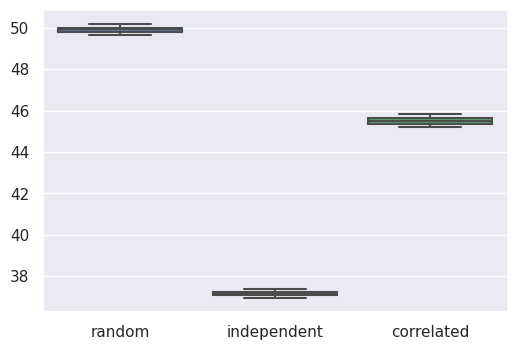

,random,independent,correlated
0,49.9342,37.2607,45.5042
1,50.0036,37.3839,45.8275
2,50.1339,37.1014,45.3002
3,50.2038,37.2785,45.7822
4,49.7899,37.0146,45.5119
5,49.8091,37.0951,45.4902
6,49.7355,37.1291,45.3118
7,49.9518,37.2115,45.6428
8,49.9401,36.9373,45.2168
9,49.6333,37.1460,45.6694


In [50]:
mean_collection = pd.DataFrame()
mean_collection['random'] = random_means
mean_collection['independent'] = independet_means
mean_collection['correlated'] = correlated_means

plt.figure(dpi=100)
sns.boxplot(data=mean_collection);                             
plt.show()
mean_collection

we know the real compas data set age attributes has the mean value of 35.143. Compare to three modes, the independent mode has the mean value that is closet to the ground truth. This is because indepdent mode, we replace the feature we want to protect with values that follow the same distribution as the original data. Thus, the mean value of age attribute is very close to the ground truth. 

In the random mode, we replace feature we want to protect with numbers randomly drawn from the uniform distribution. Thus, with number drawn from an uniform distribution with min = 0, max = 100, the mean value is close to 50 rather than the ground truth. 

In the correlated attribute mode, we replaces the feature we want to protect with values based on the conditional distribution of all the features in the database. Thus, the distribution of age would not be significantly close to the ground truth as the independent attribute could be. However, it still perform better than the random mode because it still takes consideration of the original age distribution in the real data set. 

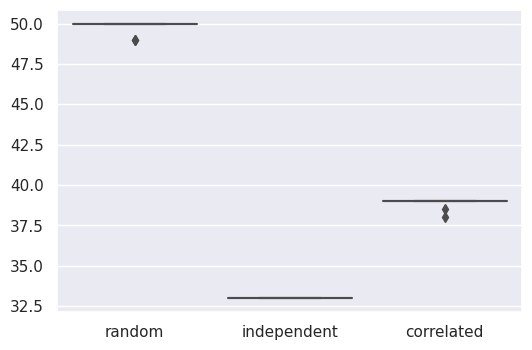

,random,independent,correlated
0,50.0,33.0,39.0
1,50.0,33.0,39.0
2,50.0,33.0,39.0
3,50.0,33.0,39.0
4,49.0,33.0,39.0
5,50.0,33.0,39.0
6,49.0,33.0,38.5
7,50.0,33.0,39.0
8,50.0,33.0,38.0
9,50.0,33.0,39.0


In [51]:
median_collection = pd.DataFrame()
median_collection['random'] = random_medians
median_collection['independent'] = independet_medians
median_collection['correlated'] = correlated_medians

plt.figure(dpi=100)
sns.boxplot(data=median_collection);                             
plt.show()
median_collection

we know the real compas data set age attributes has the median value of 32. Compare to three modes, the independent mode has the median value that is closet to the ground truth. This is because indepdent mode, we replace the feature we want to protect with values that follow the same distribution as the original data. Thus, the median value of age attribute(33) is very close to the ground truth(32).Also the spread is very narrow because median was not affected much when we change the seed because the underlying distribution did not change much. 

In the random mode, we replace feature we want to protect with numbers randomly drawn from the uniform distribution. Thus, with numbers drawn from an uniform distribution with min = 0, max = 100, the median value is close to 50 rather than the ground truth. The spread is very narrow because median was not affected much when we change the seed because the uniform distribution did not change much.

In the correlated attribute mode, we replaces the feature we want to protect with values based on the conditional distribution of all the features in the database. Thus, the distribution of age would not be significantly close to the ground truth as the independent attribute could be. However, it still perform better than the random mode because it still takes consideration of the original age distribution in the real data set. The median value is around 39 which is a bit larger than the actual median. 

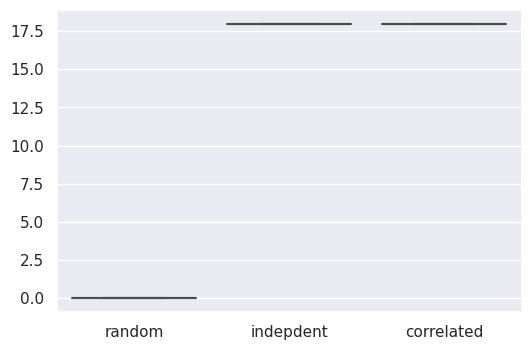

In [55]:
min_collection = pd.DataFrame()
min_collection['random'] = random_mins
min_collection['indepdent'] = independet_mins
min_collection['correlated'] = correlated_mins
min_collection
plt.figure(dpi=100)
sns.boxplot(data=min_collection);   
plt.show()


For the min, we could see that indepdent attribute mode and correlated attribute mode both are both at the ground truth. However, the random mode is not because it follows the uniform distribution with min = 0 and max = 100. 

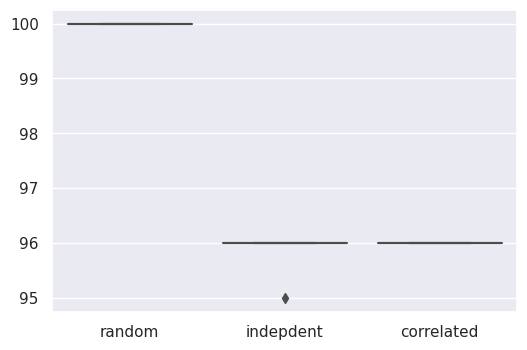

In [56]:
max_collection = pd.DataFrame()
max_collection['random'] = random_maxs
max_collection['indepdent'] = independet_maxs
max_collection['correlated'] = correlated_maxs
max_collection
plt.figure(dpi=100)
sns.boxplot(data=max_collection);   
plt.show()


For the max, we could see that indepdent attribute mode and correlated attribute mode both are both at the ground truth. However, the random mode is not because it follows the uniform distribution with min = 0 and max = 100. 

## Part (c)

Study how metrics of Q3 changes for data generation mode B, C, and D, as you vary __epsilon__.

- Plot the distributions of KL-divergence scores (10 samples each) with box-and-whiskers plots where you treat epsilon as the X-axis and generation settings as subplots. 


# Independent Attribute Mode 

In [ ]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html



In [58]:

description_files_compasC = {
                     'independent attribute mode':    'description(independent).json', 
                     'correlated attribute mode 1':     'description(correlated 1).json',
                     'correlated attribute mode 2':     'description(correlated 2).json'}





synthetic_data_files_compasC = {
                        'independent attribute mode': 'synthetic data(independent).csv', 
                        'correlated attribute mode 1':  'synthetic data(correlated 1).csv',
                        'correlated attribute mode 2':  'synthetic data(correlated 2).csv'
                        }


   

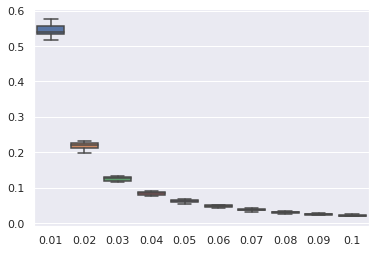

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
0,0.534549,0.221263,0.130941,0.087459,0.066181,0.050840,0.041761,0.033211,0.027864,0.025320
1,0.552906,0.228723,0.126327,0.085235,0.061436,0.046674,0.036086,0.030426,0.024858,0.020859
2,0.576883,0.230662,0.133246,0.089229,0.065882,0.052008,0.036500,0.029723,0.025055,0.021500
3,0.546147,0.222805,0.130018,0.090750,0.066310,0.049039,0.040419,0.032116,0.026667,0.022278
4,0.533585,0.198921,0.115403,0.081063,0.062556,0.046640,0.037140,0.029085,0.021980,0.019623
5,0.517679,0.199601,0.116430,0.076691,0.056155,0.043382,0.031862,0.025880,0.021635,0.018921
6,0.562543,0.215668,0.117293,0.077797,0.058773,0.046882,0.036829,0.029780,0.025571,0.020759
7,0.534745,0.219658,0.120032,0.077484,0.053508,0.041549,0.031514,0.026255,0.021875,0.018454
8,0.559233,0.225053,0.131228,0.085770,0.060178,0.046319,0.036857,0.027136,0.022133,0.019218
9,0.532514,0.211282,0.126195,0.085165,0.064549,0.051852,0.040105,0.032080,0.026854,0.023528


In [59]:
seeds = [99,5,45,30,88,36,21,12,68,1]
epsilons =  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
KL_independent = pd.DataFrame()

count = 0 
for epsilon in epsilons:
  kl_list = []
  current_e = epsilon
  #describe the data 
  describer.describe_dataset_in_independent_attribute_mode(real_data_file, epsilon=current_e)
  describer.save_dataset_description_to_file(description_files_compasC['independent attribute mode'])
  for seed in seeds:
    #condition B
    current_s = seed
    #generate the data
    generator.generate_dataset_in_independent_mode(n=output_data_size,description_file=description_files_compasC['independent attribute mode'],seed=current_s,)
    #save the data 
    generator.save_synthetic_data(synthetic_data_files_compasC['independent attribute mode'])
    #convert to dataframe
    synthetic_independent_compasC = pd.read_csv(synthetic_data_files_compasC['independent attribute mode'])
    #calculate the KL score 
    kl = kl_test(df_real, synthetic_independent_compasC, 'race')
    kl_list.append(kl)
    count += 1
  KL_independent[current_e] = kl_list




sns.boxplot(data=KL_independent);                             
plt.show()
KL_independent


We know that when the KL divergence is close to 0, the two distributions perfectly matches, and when KL divergence is larger, the two distributions start to vary and we also know that smaller values of epsilon mean that more privacy is preserved, or more specifically, the real and synthetic datasets are not distinguishable and information cannot be extracted by a differential attack.

Combined the above two expalainations, we understand that as epsilons decreases, more privacy is preserved and two distributions start to vary which would later lead to increase in the KL divergence. 

In the case of indepdent attribute mode, since we replace the feature we want to protect with values that follow the same distribution as the original data.
So the distribution of race is considered to be the closet to the original race ditribution across the other two synthetic distributions created. Thus, the  kl divergence is the smallest compare to the kl divergence results from other the condition C and D. 



# correlated attribute mode with epsilon = 0.1, with Bayesian network degree k=1

In [60]:
#generate data set for hw_compas C: correlated attribute mode with epsilon = 0.1, with Bayesian network degree k=1
describer.describe_dataset_in_correlated_attribute_mode(real_data_file, 
                                                        epsilon=0.1, 
                                                        k=1)
describer.save_dataset_description_to_file(description_files_compas['correlated attribute mode 1'])
generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size,description_file=description_files_compas['correlated attribute mode 1'],seed=0,)

#save the synethetic data 
generator.save_synthetic_data(synthetic_data_files_compas['correlated attribute mode 1'])

#convert to dataframe
synthetic_correlated_1_compas = pd.read_csv(synthetic_data_files_compas['correlated attribute mode 1'])

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attri

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
0,0.808912,0.603629,0.458435,0.362377,0.297087,0.239735,0.217929,0.187769,0.166709,0.145337
1,0.775029,0.602172,0.473612,0.358891,0.296012,0.228659,0.204249,0.176877,0.156245,0.144097
2,0.783133,0.580870,0.457840,0.347314,0.280760,0.233032,0.215201,0.181479,0.159605,0.136912
3,0.760282,0.591771,0.449896,0.360795,0.301174,0.253618,0.209917,0.189227,0.173253,0.152613
4,0.786299,0.612777,0.452093,0.346399,0.298895,0.242566,0.206357,0.189516,0.173223,0.150913
5,0.781598,0.609844,0.443167,0.362169,0.288116,0.239222,0.211979,0.178212,0.162990,0.146957
6,0.791986,0.571082,0.454514,0.363231,0.297934,0.240380,0.209230,0.167159,0.164894,0.140453
7,0.765467,0.575241,0.463608,0.357196,0.286488,0.238005,0.206580,0.178113,0.153243,0.133774
8,0.762695,0.584988,0.461848,0.360952,0.292210,0.250488,0.212809,0.191211,0.164041,0.147854
9,0.808934,0.631208,0.482262,0.393374,0.320996,0.266493,0.217047,0.200504,0.180038,0.160541


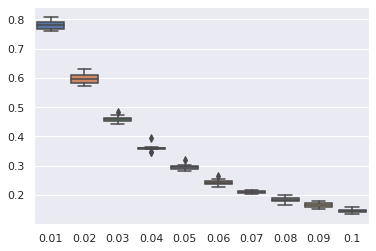

In [61]:
seeds = [99,5,45,30,88,36,21,12,68,1]
epsilons =  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
KL_correlated_1 = pd.DataFrame()

for epsilon in epsilons:
  kl_list = []
  current_e = epsilon
  #describe the data 
  describer.describe_dataset_in_correlated_attribute_mode(real_data_file, 
                                                        epsilon=current_e, 
                                                        k=1)
  describer.save_dataset_description_to_file(description_files_compasC['correlated attribute mode 1'])
  for seed in seeds:
    current_s = seed
    #generate the data
    generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size,description_file=description_files_compasC['correlated attribute mode 1'],seed=current_s,)
    #save the data 
    generator.save_synthetic_data(synthetic_data_files_compasC['correlated attribute mode 1'])
    #convert to dataframe
    synthetic_correlated_1_compas = pd.read_csv(synthetic_data_files_compasC['correlated attribute mode 1'])
    #calculate the KL score 
    kl = kl_test(df_real, synthetic_correlated_1_compas, 'race')
    kl_list.append(kl)

  KL_correlated_1[current_e] = kl_list




sns.boxplot(data=KL_correlated_1);                             
KL_correlated_1



In the case of correlated attribute mode with k = 1, 
The correlated attribute mode replaces the feature we want to protect with values based on the conditional distribution of all the features in the database. Thus, the race distribution under condition C is not as close to the original race distribution as the race distribution under condition B. However, we could still see the trend of decreasing epsilons would in turn increase the KL divergence, which means that decreasing epsilons would increase the privacy preserved. 

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attri

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
0,1.045372,0.785376,0.593396,0.430772,0.352364,0.306995,0.263774,0.223268,0.199892,0.174864
1,1.052349,0.792234,0.612065,0.441751,0.360839,0.305422,0.263175,0.235714,0.199572,0.175585
2,1.066917,0.796145,0.622714,0.471037,0.370383,0.308594,0.263991,0.211849,0.191041,0.167748
3,1.061372,0.796779,0.637191,0.462320,0.368188,0.309467,0.276293,0.238884,0.211268,0.184653
4,1.055752,0.779107,0.618658,0.445840,0.372270,0.314520,0.271213,0.234868,0.212967,0.189331
5,1.071713,0.801810,0.626465,0.451777,0.359821,0.299615,0.264049,0.223728,0.188156,0.166992
6,1.039520,0.791465,0.638496,0.452404,0.360107,0.313423,0.267484,0.236080,0.204594,0.175527
7,1.030433,0.768661,0.593066,0.436529,0.349713,0.292030,0.258005,0.217236,0.193064,0.161426
8,1.063956,0.814908,0.642320,0.476740,0.387674,0.326615,0.270361,0.234301,0.206780,0.185664
9,1.042284,0.795127,0.624831,0.468012,0.375486,0.301347,0.268928,0.228785,0.185964,0.161417


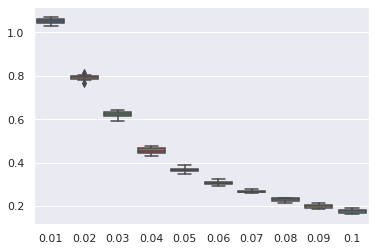

In [62]:
seeds = [99,5,45,30,88,36,21,12,68,1]
epsilons =  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
KL_correlated_2 = pd.DataFrame()

for epsilon in epsilons:
  kl_list = []
  current_e = epsilon
  #describe the data 
  describer.describe_dataset_in_correlated_attribute_mode(real_data_file, 
                                                        epsilon=current_e, 
                                                        k=2)
  describer.save_dataset_description_to_file(description_files_compasC['correlated attribute mode 2'])
  for seed in seeds:
    current_s = seed
    #generate the data
    generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size,description_file=description_files_compasC['correlated attribute mode 2'],seed=current_s,)
    #save the data 
    generator.save_synthetic_data(synthetic_data_files_compasC['correlated attribute mode 2'])
    #convert to dataframe
    synthetic_correlated_2_compas = pd.read_csv(synthetic_data_files_compasC['correlated attribute mode 2'])
    #calculate the KL score 
    kl = kl_test(df_real, synthetic_correlated_2_compas, 'race')
    kl_list.append(kl)

  KL_correlated_2[current_e] = kl_list




sns.boxplot(data=KL_correlated_2);                             
KL_correlated_2

In the case of correlated attribute mode with k = 2, 
The correlated attribute mode replaces the feature we want to protect with values based on the conditional distribution of all the features in the database. And in this mode, every children would have maximum of 2 parents. The race distributions with various epsilons under condition D are not as close to the original race distribution as the race distribution under condition C because correlated attribute mode with k = 1 does a better job recreating the race distribution of the original compas race distribution . However, we could still see the trend of decreasing epsilons would in turn increase the KL divergence, which means that decreasing epsilons would increase the privacy preserved. 